## Colour ranges
the HSV ranges like H from 0-179, S and V from 0-255

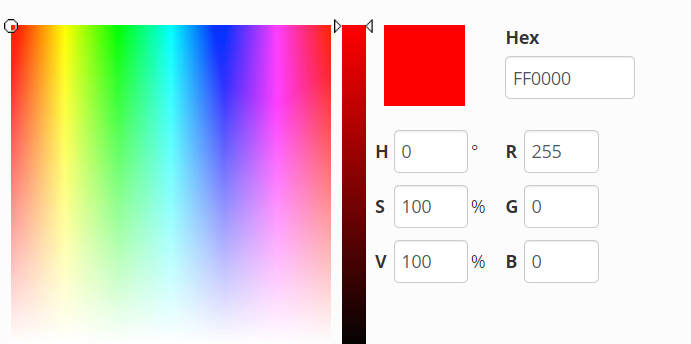

https://alloyui.com/examples/color-picker/hsv.html

## IMAGE SHAPE
(480, 640, 3)

-x ---------- +x

-y<br />
| <br />
| <br />
| <br />
| <br />
| <br />
| <br />/
+y

pixel count: 0
no more objects in scene of colour: green
pixel count: 11594
centerpoints at: x: 246 y: 344
centerpoints at: x: 163 y: 332
centerpoints at: x: 165 y: 142
top left points are: x: 165 y: 142
distance from center: x: -155 y: -98


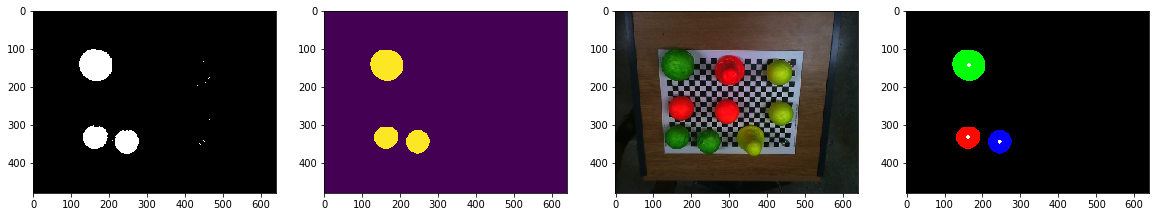

pixel count: 4719
centerpoints at: x: 64 y: 435
centerpoints at: x: 1 y: 132
top left points are: x: 1 y: 132
distance from center: x: -319 y: -108


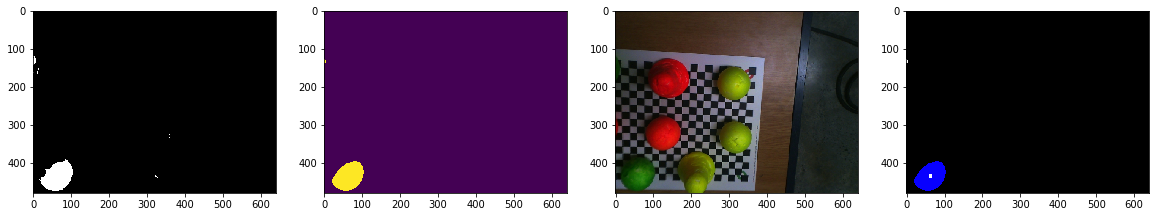

pixel count: 10228
centerpoints at: x: 264 y: 386
centerpoints at: x: 180 y: 383
centerpoints at: x: 162 y: 194
top left points are: x: 162 y: 194
distance from center: x: -158 y: -46


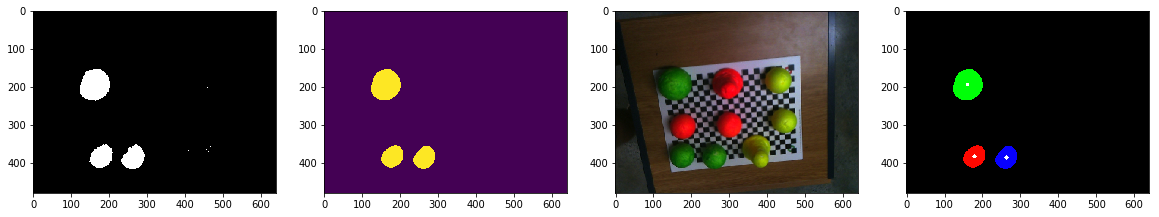

pixel count: 9772
centerpoints at: x: 261 y: 371
centerpoints at: x: 178 y: 369
centerpoints at: x: 160 y: 184
top left points are: x: 160 y: 184
distance from center: x: -160 y: -56


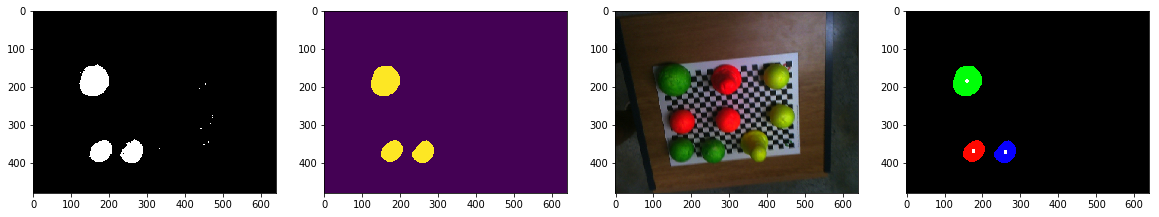

pixel count: 3773
centerpoints at: x: 236 y: 109
centerpoints at: x: 166 y: 107
top left points are: x: 166 y: 107
distance from center: x: -154 y: -133


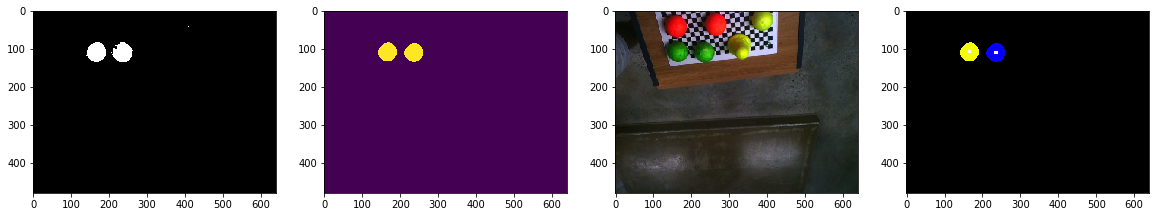

pixel count: 7650
centerpoints at: x: 281 y: 282
centerpoints at: x: 212 y: 280
centerpoints at: x: 194 y: 120
top left points are: x: 194 y: 120
distance from center: x: -126 y: -120


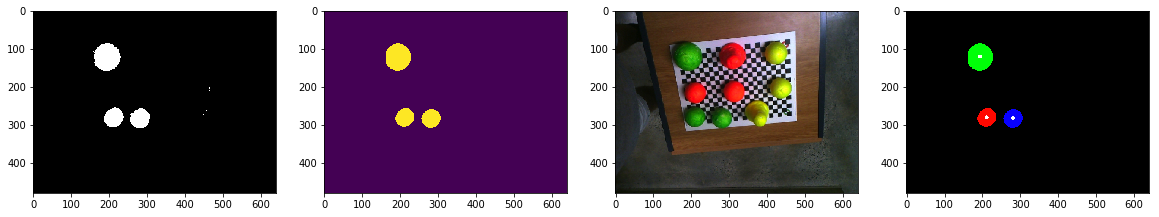

pixel count: 11453
centerpoints at: x: 263 y: 299
centerpoints at: x: 349 y: 296
centerpoints at: x: 226 y: 97
top left points are: x: 226 y: 97
distance from center: x: -94 y: -143


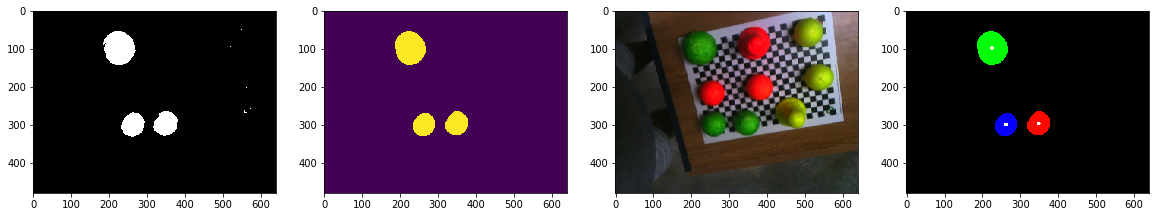

pixel count: 15304
centerpoints at: x: 181 y: 346
centerpoints at: x: 77 y: 341
centerpoints at: x: 58 y: 89
top left points are: x: 58 y: 89
distance from center: x: -262 y: -151


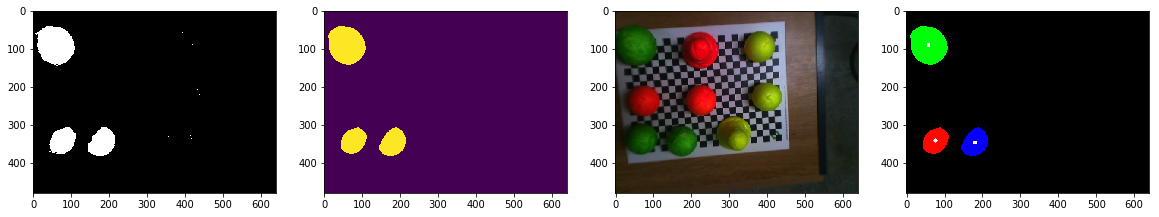

pixel count: 13640
centerpoints at: x: 270 y: 259
centerpoints at: x: 373 y: 244
centerpoints at: x: 210 y: 28
top left points are: x: 210 y: 28
distance from center: x: -110 y: -212


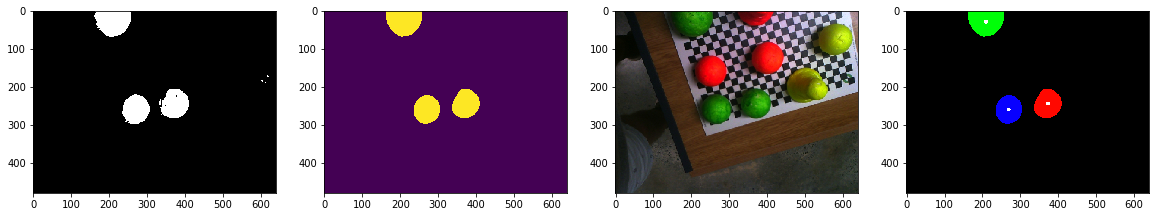

In [13]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np


detect_photos(colour='green')

In [12]:


def detect_photos(colour):

    files = glob.glob("Images/*")[:10]

    # two ranges because red stretchs over the Hue colour range
    
    ##RED
    lower_red_1 = (0,100,50)
    upper_red_1 = (5,255,255)

    lower_red_2 = (170,100,50)
    upper_red_2 = (180,255,255)
    
    ##GREEN
    lower_green = (45, 100, 50)
    upper_green = (65, 255, 255)
    
    ##YELLOW
    lower_yellow = (25, 100, 50)
    upper_yellow = (40, 255, 255)


    for f in files:
        # reading in image to RGB and HSV
        img_RGB = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
        img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
        
        if colour == 'red':

            # Create two masks
            mask1 = cv2.inRange(img_HSV, lower_red_1, upper_red_1)
            mask2 = cv2.inRange(img_HSV, lower_red_2, upper_red_2)

            # XOR masks
            mask = cv2.bitwise_xor(mask1, mask2)
        elif colour == 'green':
            mask = cv2.inRange(img_HSV, lower_green, upper_green)
        
        elif colour == 'yellow':
            mask = cv2.inRange(img_HSV, lower_yellow, upper_yellow)
            
        
        # bitwise and with image
        result = cv2.bitwise_and(img_HSV, img_HSV, mask=mask)


        # put median blur over the top
        median = cv2.medianBlur(mask,23)
        
        print("pixel count: " + str(cv2.countNonZero(median)))
        
        if cv2.countNonZero(median) < 2000:
            print("no more objects in scene of colour: " + colour)
#             return None
            continue

        # find connected components
        ret, labels = cv2.connectedComponents(median)

        # Map component labels to hue val
        label_hue = np.uint8(179*labels/np.max(labels))
        blank_ch = 255*np.ones_like(label_hue)
        labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

        # cvt to BGR for display
        labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

        # set bg label to black
        labeled_img[label_hue==0] = 0

        #########################################################
        ## Finding Centers!
        ret,thresh = cv2.threshold(median,127,255,0)

        # find contours in the binary image
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        
        distance_min = 100000
        for c in contours:
            # calculate moments for each contour
            M = cv2.moments(c)

            # calculate x,y coordinate of center
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.circle(labeled_img, (cX, cY), 5, (255, 255, 255), -1)
                
                distance_new = np.sqrt(cX**2 + cY**2)
                if distance_new < distance_min:
                    distance_min = distance_new
                    X_top_left = cX
                    Y_top_left = cY
                
                print("centerpoints at: x: " + str(cX) + " y: " + str(cY))
        
        print("top left points are: x: " + str(X_top_left) + " y: " + str(Y_top_left))
        
        X_from_center = X_top_left - (640/2)
        Y_from_center = Y_top_left - (480/2)
        
        print("distance from center: x: " + str(X_from_center) + " y: " + str(Y_from_center))
        
        # print out figures
        figure = plt.figure(figsize=(20,20))
        plt.subplot(1, 4, 1)
        # mask
        plt.imshow(mask, cmap="gray")
        plt.subplot(1, 4, 2)
        # median blue
        plt.imshow(median)
        #original image
        plt.subplot(1, 4, 3)
        plt.imshow(img_RGB)
        # final 
        plt.subplot(1, 4, 4)
        plt.imshow(labeled_img)

        plt.show()
        
#         return [X_from_center, Y_from_center]

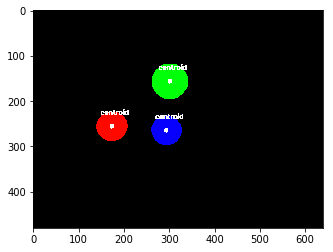

In [59]:
plt.imshow(labeled_img)

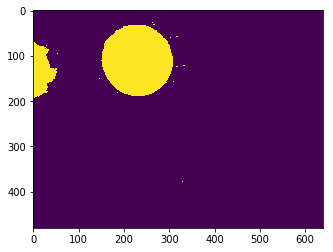

In [80]:
plt.imshow(img_RGB)
plt.show()

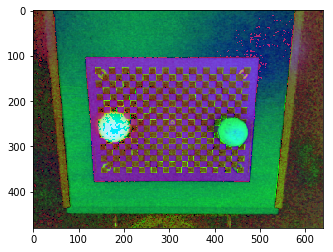

In [55]:
plt.imshow(img_HSV)
plt.show()

In [102]:
np.sqrt(4)

2.0

In [104]:
2**5

32

In [120]:
if None:
    print(1)